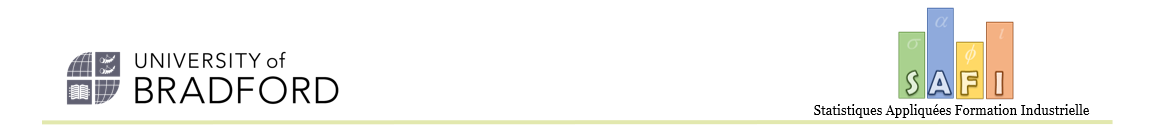

<font size=16>**Tutorial 12: Advanced Response Surface Methods**

# About this session

## Objectives

* to develop your skills in planning advanced DoEs, and fitting response surface models using Python packages.

## Engineering Scenario

**Calibration Study for Variable Valve Timing (VVT) Engine**

* This case study is part of an exercise to develop an optimal Variable Camshaft Timing (VCT) calibration for a 1.6l 16-valve TI-VVT engine. To support the optimisation study, a detailed DoE was planned at 9 points in the Engine speed / load space, with the VCT variables defined in the table below.

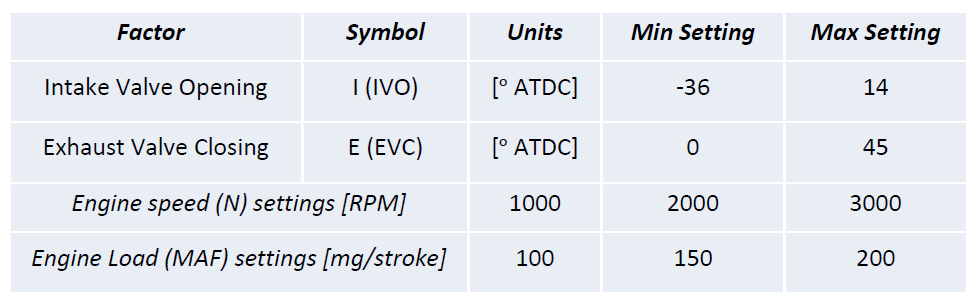

# Tutorial Tasks

Design and analyse a latin hypercube experiment.

1. Create a DoE (Test Plan) for IVO and EVO only (i.e. assume that RPM and MAF are fixed) using a Latin Hypercube Design with 40 runs (samples). Convert your DoE into engineering (uncoded) units using the ranges in the table above.

2. Load the engine test data provided and fit response surface models for Torque, sdNMEP (standard deviation of NMEF- used as an indicator for combustion stability) and NOx.


**Note: In this tutorial only the Torque model has been generated and the others are left for you to do as an excercise. The process is the same as the one demonstrated for the Torque model.**
---

# Packages and special code

In this section we install any packages that are not standard Colab then we import the packages that we need need into the Python namespace.



## Uploading files to Colab

1. Click on the "Files" icon on the left hand side of the Colab window (it is a folder symbol). This will take you to the "Files" panel.
2. Drag and drop the files `M05BU.py` and `M05Data.xlsx` onto the Files panel.
3. Click on the "Contents" icon (to the left of the word "Files") to go to the Table of Contents panel.
4. Use the `ls` command to get a folder listing (useful for copying and pasting file names) by running the next cell.

In [ ]:
ls

## Import the courseware

Run the next cell to import the custom courseware. We have used the alias, `bu`, as shorthand for "Bradford Utilities"

In [ ]:
import M05BU as bu

## Package imports

Run the next cell to import the necessary packages into the Python namespace.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
import pandas as pd
import seaborn as sns
from itertools import product
from seaborn.widgets import LinearSegmentedColormap
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# Task 1

## 1.1 Generate a latin hypercube design using coded units

This introductory tutorial task is only about generating a local model, i.e. at one engine speed-load point; we are keeping the engine load and speed constant and varying the timing of the Inlet Valve Opening (IVO) and Exhuast Valve Closing (EVC).

We begin by generating a latin hypercube design in coded units.

The function  for geneating a latin hypercube is as follows:

```
bu.lhs(n, samples, criterion, iterations)
```
where

- `n`: an integer that designates the number of factors (required)
- `samples`: this is the number of experimental "runs" (optional - default: n)
- `criterion`: this tells lhs how to sample the points (optional - default: `None`, which simply randomizes the points within the intervals):
    * “center” or “c”: centre the points within the sampling intervals
    * “maximin” or “m”: maximize the minimum distance between points, but place the points in randomized locations within the intervals
    * “centermaximin” or “cm”: same as “maximin”, but centred within the intervals
    * “correlation” or “corr”: minimize the maximum correlation coefficient

- iterations : The number of iterations; in the maximin and correlations algorithms (Default: 5).

Run the following cell to generate a latin hypercube design for 2 variables.

In [ ]:
df = bu.lhs(2,samples=40, criterion="maximin") # generating lhs design, this function generates an array
df = pd.DataFrame(df,columns=['IVO','EVC']) # converting array into a dataframe

bu.printMarkdown('### Latin Hypercube Design in Coded Units:' + '\n')
display(df.head()) # display the top few rows of the design
ax = df.plot.scatter(x='IVO', y='EVC') # plot the design
ax.set_title('Latin Hypercube Design in Coded Units');

Try running the cell above a few times. You should see that the pattern of points in the DoE is different each time because the algorithm is a random one.


## 1.2 Convert the latin hypercube design to uncoded (engineering) units

The variables are in coded units (0 to 1 this time not the -1 to +1 that we have used before) so we need to convert them to uncoded engineering units using the method that we used in previous Tutorials.

Run the next cell to perform the conversion.

Note:
The code also saves a copy of the actual design as an Excel file so that it can be downloaded and used to carry out the experiment.

In [ ]:
# Min Value
actual_lows = {'IVO': -36,
               'EVC': 0,}
# Max Value
actual_highs = {'IVO': 14,
                'EVC': 45,}

df = 2*df - 1 # Convert ranges to -1 to +1
actual_design = bu.dexpy.design.coded_to_actual(df, actual_lows, actual_highs) # converting the design into Engineering Units

bu.printMarkdown('### Latin Hypercube Design in Engineering Units:' + '\n'),

display(actual_design.head()) # print the design with engineering units
actual_design.to_excel('actual_design.xlsx', index=False) # Saving the design

ax = actual_design.plot.scatter(x='IVO', y='EVC') # plot the design
ax.set_title('Latin Hypercube Design in Engineering Units');

# Task 2

## 2.1 Read the course data

Having designed the experiment, we are not able to use it in the analysis because no two latin hypercube designs are the same so we have some data from a real latin hypercube engine mapping experiment.

Run the following cell to load the data for this tutorial.

In [ ]:
df = pd.read_excel('M05Data.xlsx', sheet_name='Data for Tutorial 12')
df.head()

The plot shows that the design is the same (LH, two x-variables, 40 samples) as the one that we produced in **Task 1** but, due to the random nature of LH designs, the actual points chosen are not the same.

Wecan visualise the quality of the design and the correlation of the responses with each other and the factors by producing a **correlation matrix heat map** as follows:

In [ ]:
# Create Correlation Matrix
corr_matrix = df.corr()

# Create a correlation matrix heat map
sns.heatmap(corr_matrix, annot=True,
            linewidths=0.5,fmt=".2f",
            cmap="PuBuGn")

plt.title('Correlation Matrix', fontsize=16)
plt.show()

Choose the response that you want to analyse by commenting out the options that you don't want:

In [ ]:
Response = 'Torque'
#Response = 'SdNMEP'
#Response = 'Nox'

Run the following cell to see a surface plot of an RBF model fit with the training data overplotted on the same axes.

In [ ]:
X = df.drop(columns=['Torque','SdNMEP','Nox']).to_numpy()
y = df[Response].to_numpy()

# define kernel for RBF modelling
kernel = C(1.0, (1e-3, 1e3)) * RBF([1, 1], (1e-3, 1e3))

# create Gaussian Process Regression object
gp = bu.MyGPR(kernel=kernel, n_restarts_optimizer=15, max_iter=1e9, gtol=1e-3)

gp.fit(X, y) # fit RBF model

ngrid = 50 # surface mesh is ngrid*ngrid
x1x2, X0p, X1p = bu.mk3Dplot_arrays(X, ngrid)

y_pred, MSE = gp.predict(x1x2, return_std=True)

Zp = np.reshape(y_pred, (ngrid, ngrid))

# build the 3D plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('IVO')
ax.set_ylabel('EVA')
ax.set_title(Response)
surf = ax.plot_surface(X0p, X1p, Zp, color='g', shade=False, alpha=0.4, antialiased=False)
pts = ax.scatter(X[:, 0], X[:, 1], y, s=100, marker='o', c='r')
# rotate the axes
ax.view_init(30, 45);

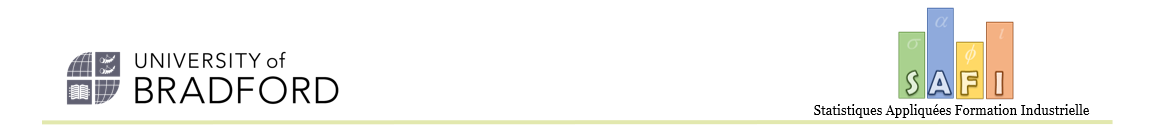

<font size=16>**Exercise 12: Advanced Response Surface Methods**

# Exercise Tasks

Fit a regression model and carry out residual analysis.

1. Analyse the SdNMEP results from the engine test latin hypercube experiment.

2. Analyse the Nox results from the engine test latin hypercube experiment.

---

# Task 1

Analyze the SdNMEP results.

# Task 2

Analyze the Nox results.